In [1]:
from sklearn.datasets import load_iris, fetch_openml
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Einstieg ins maschinelle Lernen

## Datensatz: Schwertlilien

Für unseren Einstieg ins klassische maschinelle Lernen verwenden wir den **Iris**-Datensatz, den Sie aus der ersten Übung bereits kennen. Zunächst laden wir den Datensatz, der im wesentlichen aus Merkmalsmatrix $\mathbf{X}$ und Zielvektor $\mathbf{y}$ besteht. Wie in der Statistik üblich bezeichnen wir die Spalten der Merkmalsmatrix hier auch als **Variablen**, die für jedes Iris-Exemplar den entsprechenden Merkmalswert annehmen.

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

Für überwachtes Lernen müssen wir den Datensatz in Trainings- und Testdaten aufteilen (hier je 50%). Ein Development-Set ist nicht erforderlich, da wir die Optimierung der Metaparameter später per Kreuzvalidierung vornehmen (via `GridSearchCV`).

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)

Wir überprüfen, dass der Datensatz stratifiziert aufgeteilt wurde, so dass in jedem Set genau 25 Exemplare jeder Iris-Art enthalten sind.

In [4]:
pd.concat([
    pd.Series(y_train).value_counts(), 
    pd.Series(y_test).value_counts()
], axis = 1)

,0,1
0,25,25
1,25,25
2,25,25


> **Frage:** Warum ist es sinnvoll, die Merkmalsvektoren wie in der ersten Übung zu standardisieren? Was passiert bei der Standardisierung genau? (Tipp: Denken Sie an Regularisierungsfunktionen.)

Bei der Standardisierung wird jede Variable (= Spalte der Merkmalsmatrix) so transformiert, dass sie den Mittelwert $\mu = 0$ und die Standardabweichung $\sigma = 1$ hat. Die erste Bedingung stellt sicher, dass die Werte der Variablen zentriert sind, d.h. positive und negative Werte sich gegenseitig aufheben. Die zweite Bedingung stellt sicher, dass alle Variablen die gleiche mittlere Streuung haben. Insgesamt wird erreicht, dass alle Variablen einen ähnlichen Wertebereich abdecken.

Standardisierung ist wichtig für Lernverfahren, deren Ergebnisse von den Wertebereichen der Variablen abhängen.  Dies trifft insbesondere auf alle linearen Klassifikationsverfahren mit Regularisierung zu.  Sie benötigen nämlich für eine Variable mit kleinem Wertebereich ein höheres Merkmalsgewicht, um den gleichen Effekt zu erreichen, als für eine Variable mit großem Wertebereich.  Da die Regularisierung versucht, Merkmalsgewichte klein zu halten, werden dadurch automatisch Variablen mit großem Wertebereich bevorzugt verwendet.  Im Falle des Iris-Datensatzes würde so die Länge der Blätter eine größere Rolle spielen als ihre Breite.

Als scikit-learn-Expert:innen bauen wir die Standardisierung natürlich in eine `Pipeline` ein, statt die Merkmalsmatrix vorab zu modifizieren.

## Lineare Klassifikation

Wir trainieren und evaluieren nun einen lineares Klassifikator.  Als Standardverfahren bietet sich **Logistic Regression** an, die wir in einigen Wochen auch selbst mit Hilfe von NumPy implementieren werden. Im Gegensatz zu unserer eigenen Implementierung unterstützt Scikit-Learn auch multinomiale Klassifikationsprobleme mit mehr als zwei Kategorien.

Wir erstellen eine Pipeline mit zwei Komponenten: Standardisierung (`StandardScaler`) und Klassifikation (`LogisticRegression`). Eine Komponente zur Merkmalsextraktion benötigen wir nicht, da als Eingabe ja schon eine numerische Merkmalsmatrix vorliegt. Die Metaparameter der Verfahren belassen wir zunächst bei den voreingestellten Werten.

In [5]:
pipe = Pipeline([
    ('std', StandardScaler()),
    ('clf', LogisticRegression())
])

Nun können wir die Pipeline trainieren und die erreichte Genauigkeit auf den Trainingsdaten überprüfen.

In [6]:
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

0.9733333333333334

Wie erwartet erzielt das Klassifikationsverfahren auf dem kleinen Trainingsdatensatz fast perfekte Ergebnisse: nur 2 von 75 Iris-Exemplaren werden falsch klassifiziert. Interessanter ist natürlich die Evaluation auf den Testdaten.

In [7]:
pred_test = pipe.predict(X_test)
print(classification_report(y_test, pred_test, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        25
  versicolor       0.89      0.96      0.92        25
   virginica       0.96      0.88      0.92        25

    accuracy                           0.95        75
   macro avg       0.95      0.95      0.95        75
weighted avg       0.95      0.95      0.95        75



Offenbar liegt keine starke Überanpassung vor: die Ergebnisse auf den Testdaten sind nur unwesentlich schlechter. _Iris setosa_ wird dabei perfekt erkannt, nur bei der Abgrenzung zwischen _Iris versicolor_ und _Iris virginica_ kommt es zu ingesamt 4 Fehlern.

> **Frage:** Können Sie das Evaluationsergebnis erklären, wenn Sie sich die Visualisierung aus der ersten Übung anschauen?

_Iris setosa_ grenzt sich bereits anhand der Länge und Breite der Blütenblätter klar von den anderen beiden Arten ab und bildet ein eigenes Cluster. Sogar ein unüberwachtes Lernverfahren würde die _Iris setosa_-Exemplare fehlerfrei erkennen. Die beiden anderen Arten unterscheiden sich auch deutlich (was in der dreidimensionalen Visualisierung noch besser sichtbar wird), so dass hier ebenfalls gute Klassifikationsergebnisse zu erwarten sind.  Allerdings gibt es einen kleinen Bereich, in dem _Iris versicolor_ und _Iris virginica_ überlappen.  Da keine weiteren Merkmale als die vier Blattmaße zur Verfügung stehen, muss es hier notwendigerweise zu Klassifikationsfehlern kommen.

Die Parameter eines linearen Klassifikators können intuitiv als **Merkmalsgewichte** interpretiert werden (im Gegensatz zu den meisten komplexeren Lernverfahren, die oft schwer anschaulich zu interpretieren sind). 

In [8]:
W = pipe['clf'].coef_
b = pipe['clf'].intercept_

print(W.round(3))
print()
print(b.round(3))

[[-1.044  0.787 -1.547 -1.401]
 [ 0.468 -0.441 -0.065 -0.649]
 [ 0.576 -0.346  1.612  2.05 ]]

[-0.392  1.553 -1.162]


> **Frage:** Wofür stehen $\mathbf{W}$ und $\mathbf{b}$? Ordnen Sie die Merkmalsgewichte den Kategorien und Variablen zu. Können Sie die Gewichte anschaulich interpretieren? (Tipp: schauen Sie sich dazu wieder die Visualisierungen aus der ersten Übung an.)

$\mathbf{W}$ ist eine $3\times 4$-Matrix von Merkmalsgewichten.  Offenbar entsprechen die Zeilen den drei Kategorien (Iris-Arten) und die Spalten den vier Variablen (Länge und Breite der Blätter). Es bietet sich an, die Matrix (als Pandas-DataFrame) entsprechend zu beschriften.

In [9]:
pd.DataFrame(W, index=iris.target_names, columns=iris.feature_names).round(4)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
setosa,-1.0441,0.7872,-1.5470,-1.4012
versicolor,0.4684,-0.4408,-0.0648,-0.6490
virginica,0.5757,-0.3465,1.6118,2.0502


In der Vorlesung haben wir die Parameter der binären linearen Klassifikation kennengelernt: die Diskriminantenfunktion $h(\mathbf{x})$ für positive vs. negative Klasse wird beschrieben durch einen Vektor $\mathbf{w}$ von Merkmalsgewichten und die Verschiebung $b$. Offensichtlich wird hier für jede der drei Kategorien eine eigene Diskriminantenfunktion $h_i(\mathbf{x})$ gelernt. Bei der Anwendung des Klassifikators „gewinnt“ dann die Kategorie mit dem höchsten Wert, also $\max_i h_i(\mathbf{x})$.

Offenbar sind Exemplare der _Iris setosa_ durch kleine Blütenblätter (negative Gewichte für _petal length/width_) und kurze, aber breite Kelchblätter (negatives Gewicht für _sepal length_, positives Gewicht für _sepal width_) charakterisiert, was sich sehr schön aus der Visualisierung ablesen lässt. Umgekehrt haben Exemplare der _Iris virginica_ große Blütenblätter und lange Kelchblätter. Die Merkmalsgewichte für _Iris versicolor_ fallen wesentlich kleiner aus als bei den anderen beiden Kategorien. Auch diese Beobachtung lässt sich gut erklären: Nach der Standardisierung haben alle Exemplare _Iris versicolor_ Merkmalswerte nahe 0, da sie in der Mitte der Gesamtverteilung liegen. Sie werden also gewissermaßen als „neutrale“ Kategorie behandelt. Nur wenn ein Merkmalsvektor weder Eigenschaften von _Iris setosa_ noch von _Iris virginica_ zeigt, wird er der Kategorie _Iris versicolor_ zugeordnet.

Es wäre auch möglich, die Trennlinien zwischen den Kategorien (in zwei Dimensionen) bzw. Trennflächen (in drei Dimensionen) mit Hilfe der Werte von $\mathbf{W}$ und $\mathbf{b}$ zu visualisieren. Da das aber ein wenig kompliziert ist, verzichten wir hier darauf.

## Tuning

> **Aufgabe:** Für gute Lernergebnisse ist es in den allermeisten Fällen wichtig, die Metaparameter der Lernverfahren (und auch der Merkmalsextraktion und anderer Vorverarbeitungsschritte) systematisch zu optimieren. Erinnern Sie sich, wie Sie zu diesem Zweck eine systematische Grid Search durchführen können? Welche Metaparameter könnten hier von Interesse sein?

In [10]:
param_grid = {
    'std__with_mean': [True], # was passiert, wenn Sie hier auch False zulassen?
    'std__with_std': [False, True],
    'clf__C': [.01, .1, .5, 1, 10]
}

gs = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy')
gs.fit(X_train, y_train)

tbl = pd.DataFrame(gs.cv_results_)
tbl[['param_clf__C', 'param_std__with_std', 'mean_test_score']]

,param_clf__C,param_std__with_std,mean_test_score
0,0.01,False,0.893333
1,0.01,True,0.906667
2,0.1,False,0.920000
3,0.1,True,0.893333
4,0.5,False,0.946667
5,0.5,True,0.906667
6,1,False,0.973333
7,1,True,0.946667
8,10,False,0.986667
9,10,True,0.973333


Offenbar spielt die Zentrierung der Variablen eine entscheidende Rolle, da sonst oft das Training des Klassifikators fehlschlägt und Warnmeldungen ausgegeben werden. Eine stärkere Regularisierung ($C < 1$) verschlechtert die Lernergebnisse deutlich. Mit noch schwächerer Regularisierung ($C = 10$) scheint sogar noch eine kleine Verbesserung möglich zu sein. Erstaunlicherweise führt auch die Standardisierung der Variablen zu $\sigma_i = 1$ hier zu einer Verschlechterung der Ergebnisse.

Die Befunde dieses Tuning-Experiments dürfen nicht zu ernst genommen werden, da jeder Fold der Kreuzvalidierung lediglich 50 Trainings-Items und 25 Test-Items benutzt. Dies könnte auch die Verschlechterung durch Standardisierung erklären, da die Schätzung von $\sigma_i$ aus 50 Trainings-Items noch sehr unsicher ist (und möglicherweise deutlich von der Verteilung der Testdaten abweicht).

Wir evaluieren das beste Modell noch auf den Testdaten, um zu überprüfen, ob das Tuning tatsächlich zu einer Verbesserung geführt oder nur die Überanpassung erhöht hat. Leider scheint eher letzters der Fall zu sein.

In [11]:
pipe_tuned = gs.best_estimator_
pred_test = pipe_tuned.predict(X_test)
print(classification_report(y_test, pred_test, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        25
  versicolor       0.86      1.00      0.93        25
   virginica       1.00      0.84      0.91        25

    accuracy                           0.95        75
   macro avg       0.95      0.95      0.95        75
weighted avg       0.95      0.95      0.95        75



> **Aufgabe:** Probieren Sie auch andere Klassifikationsverfahren aus (z.B. SVM, SGD, Nearest Neighbour, Decision Tree). Lesen Sie dazu jeweils die Dokumentation der entsprechenden scikit-learn-Klasse unter https://scikit-learn.org/stable/user_guide.html. Wie gut funktionieren diese anderen Lernverfahren? Können Sie deren Parameter auch anschaulich interpretieren?

# Ziffernerkennung

## Datensatz: handgeschriebene Ziffern (MNIST)

Der MNIST-Datensatz ist ein klassischer (aber ziemlich einfacher) „Benchmark“ der Bildverarbeitung, bei dem es speziell um die Erkennung handgeschriebener Ziffern geht (z.B. für Postleitzahlen oder Überweisungsformulare). Der Datensatz besteht aus je 7.000 Bildern der Ziffern 0, …, 9 und kann leicht mit Hilfe von Scikit-Learn geladen werden.

In [12]:
mnist = fetch_openml("mnist_784", as_frame=False)
mnist.data.shape

(70000, 784)

Die Bilder liegen haben ein Format von $28\times 28$ Pixeln, die aber als „flache“ Vektoren $\mathbf{x}\in \mathbb{R}^{784}$ gespeichert sind. Wenn wir diese Vektoren als $28\times 28$-Matrix ausgeben, sind die Ziffern erkennbar

In [13]:
np.set_printoptions(linewidth=160)
print(mnist.data[7, :].reshape((28, 28)))

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  38.  43. 105. 255. 253. 253. 253. 253. 253. 174.   6.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  43. 139. 224. 226. 252. 253. 252. 252. 252. 252. 252. 252. 158.  14.   0.   0.   0.   0.   0.]

Die Pixel werden als Graustufenwerte von 0 bis 255 gespeichert. Statt die einzelnen Pixel (als Variablen der Merkmalsvektoren) zu standardisieren, können wir sie auf den ähnlichen Bereich $[0, 1]$ umskalieren. Damit sollten die meisten Lernverfahren gut umgehen können. Tatsächlich führt die ursprüngliche Skalierung zu Problemen mit der Regularisierung einiger Lernverfahren, die dann nur mit sehr unüblichen Regularisierungsparametern gut funktionieren.

Die Zielkategorien sind hier als Zeichenketten `'0'` bis `'9'` kodiert. Wir konvertieren sie in ganzzahlige Werte, wie von den multinomialen Klassifikationsverfahren in Scikit-Learn erwartet wird. Da `fetch_openml()` leider keine Kategorienlabel zurückliefert, legen wir diese selbst in der Variablen `cat_names` an.

In [14]:
X = mnist.data / 255
y = mnist.target.astype('int')
cat_names = [str(x) for x in range(10)]

Um einen bessern Eindruck von der Aufgabenstellung zu bekommen, definieren wir eine Hilfsfunktion, die die Merkmalsvektoren als Pixelbilder anzeigt. Grundsätzlich verwenden wir dazu `plt.imgshow()` mit `cmap="binary"` für Schwarzweißbilder. Um mehrere Ziffern in einer Graphik darzustellen, fasst `mk_imagemap()` diese in eine große Matrix zusammen. Als Beispiel zeigen wir die ersten 50 Ziffern aus dem Datensatz an. Auf die zugehörigen Goldstandard-Label können wir ganz offensichtlich verzichten.

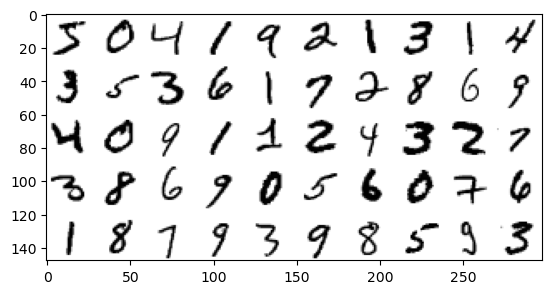

In [15]:
def mk_imagemap(data, nrow, ncol, padding=2):
    w, h = data.shape[-2:]
    data = data.reshape((-1, w, h))
    n = data.shape[0]
    image = np.zeros((nrow * h + (nrow - 1) * padding, ncol * w + (ncol - 1) * padding))
    y = 0
    k = 0
    for i in range(nrow):
        x = 0
        for j in range(ncol):
            if k <= n - 1:
                image[y:y+h, x:x+w] = data[k]
            x += w + padding
            k += 1
        y += h + padding
    return image

plt.imshow(mk_imagemap(X.reshape((70000, 28, 28)), 5, 10), cmap="binary");

Wir teilen den MNIST-Datensatz in 80% Trainingsdaten und 20% Testdaten auf (was aufgrund des großen Gesamtumfangs völlig ausreichend ist).

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape)
print(X_test.shape)

(56000, 784)
(14000, 784)


## Lineare Klassifikation

Wir beginnen wieder mit einem einfachen linearen Klassifikationsverfahren. Zur Wahl stehen neben der bisher verwendeten `LogisticRegression` unter anderem auch Support Vector Machines (nur die lineare Variante `LinearSVC` ist effizient genug) und Stochastic Gradient Descent (`SGDClassifier`). Mit letzterem werden wir uns in den nächsten Wochen noch ausführlich beschäftigen, da es eine der zentralen Grundlagen für Deep Learning darstellt.

Beachten Sie, dass die in Scikit-Learn implementierten Lernverfahren die Bilder einfach als „flache“ Merkmalsvektoren verarbeiten und ihre zweidimensionale Struktur nicht ausnutzen können. Das wird erst später mit Hilfe spezieller Deep-Learning-Modelle möglich.

Da wir es jetzt mit einer erheblich größeren Menge von Trainingsdaten und höherdimensionalen Merkmalsvektoren zu tun haben, dauert die Parameterschätzung der Lernverfahren (durch Minimierung der Kostenfunktion $J(\mathbf{w}; T) = L(\mathbf{w}; T) + \lambda C(\mathbf{w})$) wesentlich länger als bisher. Mit der Direktive `%%time` am Anfang der Zelle können wir jeweils benötigte Rechenzeit anzeigen lassen. Für die logistische Regression müssen Sie mit einer Trainingsdauer von deutlich über 1 Minute rechnen.

In [17]:
%%time
clf = LogisticRegression(C=1, max_iter=1000)
clf.fit(X_train, y_train)
print(f"Training accuracy: {clf.score(X_train, y_train):.4f}")

Training accuracy: 0.9402
CPU times: user 16min 37s, sys: 25.4 s, total: 17min 2s
Wall time: 1min 55s


Entscheidend ist natürlich wieder die Evaluation auf den Testdaten. Wie üblich verwenden wir hierzu `classification_report()`, um auch Precision und Recall für jede einzelne Kategorie zu bestimmen.

In [18]:
pred_test = clf.predict(X_test)
print(classification_report(y_test, pred_test, digits=4, target_names=cat_names))

              precision    recall  f1-score   support

           0     0.9486    0.9754    0.9618      1381
           1     0.9533    0.9727    0.9629      1575
           2     0.9278    0.9006    0.9140      1398
           3     0.8966    0.8922    0.8943      1428
           4     0.9331    0.9194    0.9262      1365
           5     0.8850    0.8709    0.8779      1263
           6     0.9359    0.9549    0.9453      1375
           7     0.9343    0.9452    0.9397      1459
           8     0.8922    0.8791    0.8856      1365
           9     0.8995    0.8943    0.8969      1391

    accuracy                         0.9216     14000
   macro avg     0.9206    0.9205    0.9205     14000
weighted avg     0.9214    0.9216    0.9214     14000



> **Frage:** Wie beurteilen Sie die Evaluationsergebnisse? Schauen Sie sich insbesondere auch Precision und Recall für die einzelnen Ziffern an. Gibt es hier auffällige Unterschiede? Wenn ja: was könnten die Ursachen dafür sein?

Insgesamt wird mit 92% Genauigkeit schon eine recht gute Ziffernerkennung erreicht. Der Klassifikator ist auch nicht wesentlich übertrainiert: auf den Trainingsdaten beträgt die Genauigkeit lediglich 94%. Diese legt nahe, dass entweder die Regularisierung zu stark gewählt wurde oder aber die lineare Klassifikation nicht mächtig genug für die Aufgabenstellung ist.

Für die Erkennung der einzelnen Ziffern sind Precision und Recall jeweils gut ausgewogen. Allerdings gibt es erhebliche Unterschiede zwischen den Ziffern. Beispielsweise werden `0` und `1` mit 96% F-Score schon sehr gut erkannt. Besonder schwierig scheinen `5`, `8` und `9` zu sein. Ein Blick auf die Beispielbilder oben legt nahe, dass es sich hier um Abgrenzungsprobleme zu ähnlichen Ziffern handeln könnte, etwa zwischen `8` und `3` oder zwischen `1` und manchen Varianten der `9`.

> **Aufgabe:** Ein besseres Verständnis der Klassifikationsfehler lässt sich oft aus der _confusion matrix_ ableiten. Erstellen Sie eine solche Fehlermatrix für unseren Ziffern-Klassifikator. Können Sie die Matrix mit Hilfe von `ConfusionMatrixDisplay` auch visualisieren?

In [19]:
print(confusion_matrix(y_test, pred_test))

[[1347    0    1    2    2    9   10    1    7    2]
 [   0 1532    6    9    1    6    2    6   11    2]
 [  13   15 1259   21   13    5   21   17   27    7]
 [   9    6   32 1274    1   46    4   16   28   12]
 [   5    7    8    5 1255    0   17    4   13   51]
 [  14    4    7   48    8 1100   24    6   38   14]
 [  14    3    9    0   13   15 1313    0    8    0]
 [   3    7   17    4   10    2    0 1379    4   33]
 [   8   21   16   38    6   44   10    4 1200   18]
 [   7   12    2   20   36   16    2   43    9 1244]]


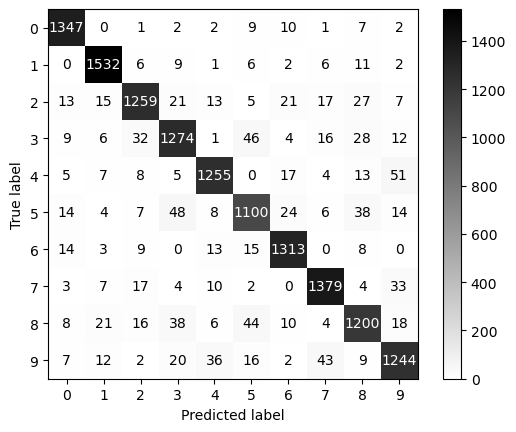

In [20]:
ConfusionMatrixDisplay.from_predictions(
    y_test, pred_test, 
    display_labels=cat_names, cmap='binary');

## Interpretation der Merkmalsgewichte

Die Interpretation der Parameter eines linearen Klassifikators als Merkmalsgewichte ist in diesem Fall besonders anschaulich. Es handelt sich nämlich (jeweils pro Kategorie = Ziffer) um Gewichtungen für die einzelnen Pixel der Bilder. Positive Gewichte markieren Pixel, die _für_ die jeweilige Ziffer sprechen; negative Gewichte markieren Pixel, die _gegen_ die Ziffer sprechen (also bei dieser Ziffer meistens nicht schwarz sind). Wir können die Gewichte also auch als $28\times 28$-Bilder visualisieren, indem wir die Gewichtsvektoren $\mathbf{w}\in \mathbb{R}^{784}$ jeweils in eine quadratische Matrix $\in \mathbb{R}^{28\times 28}$ umformen.

Zu diesem Zweck definieren wir eine kleine Hilfsfunktion, die `mk_imagemap()` zur Darstellung der 10 Gewichtsmatrizen nutzt. Entscheidend ist hierbei, den Wertebereich der Pixel so einzustellen, dass ein Gewicht von 0 genau in der Mitte liegt. (**Frage:** Warum ist das wichtig? Wie wird es in unserer Hilfsfunktion sichergestellt?)

range: [-3.08, 3.08]


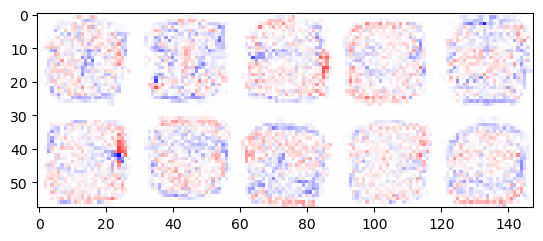

In [21]:
def plot_weights(W, cmap='bwr', vmax=None):
    image = mk_imagemap(W.reshape((-1, 28, 28)), 2, 5)
    if vmax is None:
        vmax = np.abs(image).max()
        print(f"range: [{-vmax:.2f}, {vmax:.2f}]")
    plt.imshow(image, cmap=cmap, vmin=-vmax, vmax=vmax)

plot_weights(clf.coef_)

Rot steht hier für positive Gewichte, blaue für negative, weiß für das Gewicht 0 (also Pixel, die vom Klassifikator gar nicht berücksichtigt werden). Der Farbton ist umso intensiver, je größer die Gewichte sind. Da einige Pixel sehr große Merkmalsgewichte erhalten, bleiben die Farbtöne der meisten anderen Pixel relativ schwach. Wir können mit dem Parameter `vmax=` die Darstellungsskala anpassen, um auch die mittelstarken Gewichte deutlicher zu visualisieren. Dann ist allerdings keine Unterscheidung zwischen großen und sehr großen Gewichten mehr möglich. 

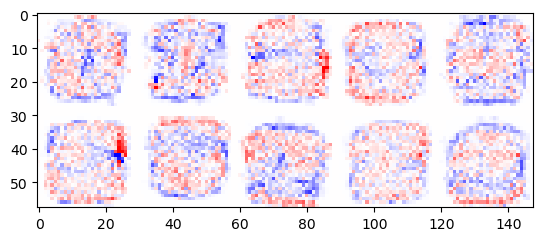

In [22]:
plot_weights(clf.coef_, vmax=2)

Mit etwas Fanatsie sind zumindest in einigen Fällen (z.B. `0`, `2`, `3`, `8`) die groben Formen der Ziffern in rot auszumachen. Negative Gewichte füllen oft Zwischenräume aus und helfen so bei der Abgrenzung von ähnlichen Ziffern. Markant ist dies z.B. bei der `0`, die in der Bildmitte einen leeren Bereich haben muss. Bei einigen anderen Ziffern (u.a. `1`, `4`, `7`) lässt sich kaum eine vertraute Form erkennen. Auch das erklärt sich schnell durch einen Blick auf die Beispielbilder: für diese Ziffern gibt es viele unterschiedliche Schreibweisen und Orientierungen, die alle in einen einzigen Gewichtsvektor kombiniert werden müssen. Grundsätzlich haben daher alle Pixel, die in _irgendeiner_ Variante vorkommen, positive Gewichte; nur Pixel, die in keiner der Varianten auftauchen, haben negative Gewichte.

> **Aufgabe:** Experimentieren Sie mit der Regularisierungsstärke und anderen Metaparameter, oder probieren Sie andere lineare Klassifikationsverfahren aus. (Da die einzelnen Trainingsdurchläufe recht langwierig sind, verzichten wir auf ein systematisches Tuning der Metaparameter.) Wie gut fallen die Ergebnisse aus? Wie veränderen sich die Pixelgewichte? Es bietet sich an, eine kleine Hilfsfunktion zur Evaluation des trainierten Klassifikators und der Visualisierung der Merkmalsgewichte zu definieren.

In [23]:
def eval_linclf(clf, on_train=True, confusion=False, plot=True, vmax=None):
    if on_train:
        print(f"Training accuracy: {clf.score(X_train, y_train):.4f}")
    pred_test = clf.predict(X_test)
    print(classification_report(y_test, pred_test, digits=4, target_names=cat_names))
    if confusion:
        print(confusion_matrix(y_test, pred_test))
    if plot:
        plot_weights(clf.coef_, vmax=vmax)

Wir probieren hier exemplarisch eine lineare SVM aus. Mit starker Regularisierung ($C = 0.01$) geht das Training erheblich schneller als bei der logistischen Regression.

In [24]:
%%time
clf = LinearSVC(C=.01, max_iter=1000)
clf.fit(X_train, y_train)

CPU times: user 3.77 s, sys: 99.7 ms, total: 3.87 s
Wall time: 3.4 s


LinearSVC(C=0.01)

Training accuracy: 0.9203
              precision    recall  f1-score   support

           0     0.9317    0.9783    0.9544      1381
           1     0.9452    0.9752    0.9600      1575
           2     0.9242    0.8891    0.9063      1398
           3     0.8996    0.8915    0.8955      1428
           4     0.9141    0.9194    0.9167      1365
           5     0.8734    0.8464    0.8597      1263
           6     0.9335    0.9593    0.9462      1375
           7     0.9274    0.9363    0.9318      1459
           8     0.8842    0.8557    0.8697      1365
           9     0.8854    0.8663    0.8757      1391

    accuracy                         0.9132     14000
   macro avg     0.9119    0.9117    0.9116     14000
weighted avg     0.9127    0.9132    0.9128     14000



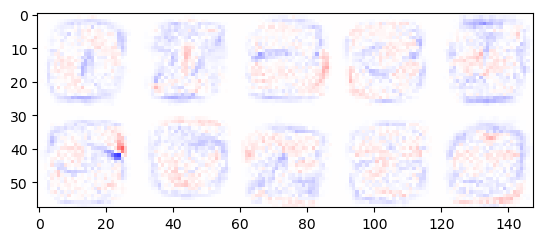

In [25]:
eval_linclf(clf, vmax=1)

Obwohl SVM als ein sehr gutes und robustes Lernverfahren gelten, fallen die Ergebnisse etwas schlechter aus als bei unserer logistischen Regression. Die Merkmalsgewichte zeigen aber ein ganz anderes Bild. Die meisten Gewichte sind deutlich schwächer (auch aufgrund der Regularisierung!), verteilen sich aber gleichmäßiger und lassen die Formen der Ziffern wesentlich besser erkennen. Schön deutlich wird, wie positive und negative Gewichte die Ränder der Ziffern hervortreten lassen.

## Stochastic Gradient Descent

In der Vorlesung haben wir Stochastic Gradient Descent bereits als ein effizientes Verfahrung zur Parameteroptimierung linearer Klassifikatoren und insbesondere der logistischen Regression kennengelernt. Hier wird die Regularisierungsstärke direkt über den Parameter `alpha` bestimmt (entsprechend unserem $\lambda$). Die Lernrate wird in der Voreinstellung automatisch angepasst. Mit der Einstellung `n_jobs = -1` können wir das Training über alle verfügbaren CPU-Kerne parallelisieren.

In [26]:
%%time
clf = SGDClassifier(alpha=1e-3, max_iter=5000, n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 7.22 s, sys: 250 ms, total: 7.47 s
Wall time: 1.27 s


SGDClassifier(alpha=0.001, max_iter=5000, n_jobs=-1)

Training accuracy: 0.9153
              precision    recall  f1-score   support

           0     0.9416    0.9689    0.9550      1381
           1     0.9510    0.9727    0.9617      1575
           2     0.8563    0.9163    0.8853      1398
           3     0.8944    0.8838    0.8890      1428
           4     0.9103    0.9143    0.9123      1365
           5     0.8790    0.8511    0.8648      1263
           6     0.9438    0.9527    0.9482      1375
           7     0.9322    0.9335    0.9329      1459
           8     0.8934    0.8286    0.8597      1365
           9     0.8920    0.8670    0.8793      1391

    accuracy                         0.9104     14000
   macro avg     0.9094    0.9089    0.9088     14000
weighted avg     0.9102    0.9104    0.9100     14000

range: [-1.10, 1.10]


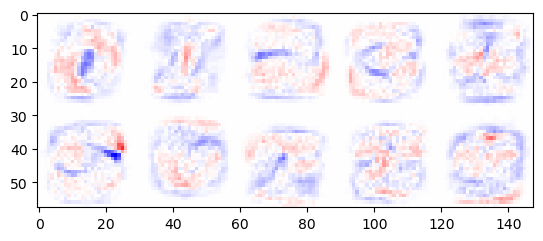

In [27]:
eval_linclf(clf)

In kürzerster Zeit erreichen wir so ein Ergebnis, das nur wenig hinter logistischer Regression und SVM zurückbleibt (mit immer noch deutlich über 90% Genauigkeit auf den Testdaten). Die Merkmalsgewichte sind deutlich besser zu interpretieren als bei `LogisticRegression` und lassen die meisten Ziffern gut erkennen.

> **Aufgabe:** Was passiert, wenn Sie die Regularisierungsstärke $\alpha$ erhöhen? Wie verändern sich Genauigkeit, Zeitaufwand und Merkmalsgewichte? Was ist, wenn Sie statt $L_2$-Regularisierung eine $L_1$-Regularisierung verwenden (`penalty`)? Versuchen Sie auch manuell die Lernrate $\eta$ (`eta0`) einzustellen, wofür Sie `learning_rate='constant'` oder `learning_rate='adaptive'` auswählen müssen.

Training accuracy: 0.8838
              precision    recall  f1-score   support

           0     0.9051    0.9674    0.9352      1381
           1     0.8779    0.9727    0.9229      1575
           2     0.9088    0.8412    0.8737      1398
           3     0.8627    0.8669    0.8648      1428
           4     0.8743    0.8916    0.8828      1365
           5     0.8812    0.7696    0.8216      1263
           6     0.8896    0.9549    0.9211      1375
           7     0.8865    0.9157    0.9009      1459
           8     0.8831    0.7971    0.8379      1365
           9     0.8522    0.8210    0.8363      1391

    accuracy                         0.8821     14000
   macro avg     0.8822    0.8798    0.8797     14000
weighted avg     0.8821    0.8821    0.8809     14000

range: [-0.27, 0.27]


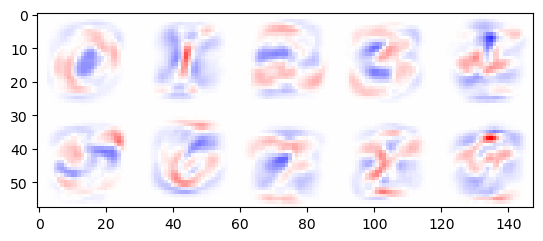

In [28]:
clf = SGDClassifier(alpha=.05, learning_rate='adaptive', eta0=.01, max_iter=5000, n_jobs=-1)
clf.fit(X_train, y_train)
eval_linclf(clf)

## Nichtlineare Klassifikation

Unsere bisherigen Erkenntnisse legen nahe, dass lineare Klassifikationsverfahren für die Ziffernerkennung nur bedingt geeignet sind. Insbesondere können sie verschiedene Schreibvarianten der gleichen Ziffer nicht separat modellieren. Wir wenden uns daher im letzten Abschnitt nichtlinearen Lernverfahren zu.

Ein Standardverfahren für nichtlineare Klassifikation sind SVM, die sich durch Auswahl eines geeigneten _kernel_ flexibel konfigurieren lassen. In unserem Fall dürften polynomiale Kerne wenig Vorteile bringen – ein kubischer Kern kann z.B. bestenfalls Kombinationen von je drei Pixeln berücksichtigen. Am flexibelsten ist der RBF-Kern, der aber sowohl beim Training als auch bei der Anwendung auf die Testdaten sehr langsam arbeitet.  Führen Sie die nächsten beiden Zellen am besten vor einer Kaffeepause aus …

In [29]:
%%time
rbf = SVC(kernel='rbf', C=1.0)
rbf.fit(X_train, y_train)

CPU times: user 3min 4s, sys: 1.83 s, total: 3min 6s
Wall time: 3min 5s


SVC()

In [30]:
%%time
eval_linclf(rbf, on_train=False, plot=False)

              precision    recall  f1-score   support

           0     0.9793    0.9949    0.9871      1381
           1     0.9873    0.9898    0.9886      1575
           2     0.9737    0.9800    0.9768      1398
           3     0.9830    0.9692    0.9760      1428
           4     0.9779    0.9729    0.9754      1365
           5     0.9825    0.9762    0.9793      1263
           6     0.9848    0.9869    0.9858      1375
           7     0.9780    0.9760    0.9770      1459
           8     0.9751    0.9773    0.9762      1365
           9     0.9683    0.9662    0.9673      1391

    accuracy                         0.9791     14000
   macro avg     0.9790    0.9789    0.9790     14000
weighted avg     0.9791    0.9791    0.9791     14000

CPU times: user 1min 25s, sys: 145 ms, total: 1min 26s
Wall time: 1min 26s


Die SVM mit RBF-Kern erzielt erheblich bessere Ergebnisse als die linearen Klassifikationsverfahren und erreicht auch ohne Tuning eine Genauigkeit von nahezu 98%. Allerdings gibt es hier keine interpretierbaren Merkmalsgewichte. 

Es gibt auch einige andere Klassifikationsverfahren, die nichtlineare Muster lernen können. Dazu gehören Entscheidungsbäume (die aber in jedem Schritt nur einen einzelnen Pixel berücksichtigen können und daher für die Ziffernerkennung eher nicht geeignet sind) und Nearest-Neighbour-Verfahren. Ein `DecisionTreeClassifier` ist schnell trainiert, zeigt aber extreme Überanpassung an die Trainingsdaten und enttäuschende Evaluationsergebnisse.

In [31]:
%%time
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

CPU times: user 9.91 s, sys: 37.1 ms, total: 9.95 s
Wall time: 9.95 s


DecisionTreeClassifier()

In [32]:
eval_linclf(dt, plot=False)

Training accuracy: 1.0000
              precision    recall  f1-score   support

           0     0.9210    0.9283    0.9246      1381
           1     0.9403    0.9606    0.9504      1575
           2     0.8609    0.8498    0.8553      1398
           3     0.8432    0.8361    0.8397      1428
           4     0.8742    0.8755    0.8748      1365
           5     0.8325    0.8266    0.8296      1263
           6     0.9063    0.8931    0.8996      1375
           7     0.9014    0.9088    0.9051      1459
           8     0.8304    0.8249    0.8276      1365
           9     0.8271    0.8325    0.8298      1391

    accuracy                         0.8753     14000
   macro avg     0.8737    0.8736    0.8737     14000
weighted avg     0.8750    0.8753    0.8751     14000



Der gelernte Entscheidungsbaum ist sehr komplex und für Menschen sicher nicht verständlich:

In [33]:
print("Insgesamt {} Entscheidungsknoten bei maximaler Tiefe von {} Schritten.".format(
    dt.tree_.node_count, dt.tree_.max_depth))

Insgesamt 7559 Entscheidungsknoten bei maximaler Tiefe von 44 Schritten.


Bei unserem großen Datensatz und einer zufälligen Aufteilung in Trainings- und Testdaten bietet sich ein Nearest-Neighbour-Verfahren an. Es dürfte sehr gute Ergebnisse lieferen, so lange sich zu jedem Bild in den Testdaten eine sehr ähnlich geschrieben Ziffer in den Trainingsdaten findet. Entscheidenen Parameter sind die Anzahl der nächsten Nachbarn, die für die Entscheidung berücksichtigt werden, sowie das zu verwendende Abstandsmaß.

Ein Training im eigentlichen Sinn findet nicht statt: es werden leglich sämtliche Trainings-Datenpunkte abgespeichert. Dafür ist die Anwendung auf neue Daten sehr zeitaufwändig, da der Abstand von jedem neuen Merkmalsvektor zu allen Trainingsdaten berechnet werden muss. Insbesondere ist es wichtig, die langwierige und wenig interessante Evaluation auf den Trainingsdaten zu überspringen.

In [34]:
nn = KNeighborsClassifier(n_neighbors=10, metric='manhattan')
nn.fit(X_train, y_train);

In [35]:
%%time
eval_linclf(nn, on_train=False, plot=False)

              precision    recall  f1-score   support

           0     0.9677    0.9964    0.9818      1381
           1     0.9191    0.9956    0.9558      1575
           2     0.9901    0.9263    0.9571      1398
           3     0.9556    0.9650    0.9603      1428
           4     0.9746    0.9553    0.9649      1365
           5     0.9508    0.9485    0.9497      1263
           6     0.9686    0.9862    0.9773      1375
           7     0.9511    0.9726    0.9617      1459
           8     0.9880    0.9011    0.9425      1365
           9     0.9503    0.9475    0.9489      1391

    accuracy                         0.9601     14000
   macro avg     0.9616    0.9594    0.9600     14000
weighted avg     0.9610    0.9601    0.9600     14000

CPU times: user 10min 3s, sys: 1.83 s, total: 10min 5s
Wall time: 1min 10s


Auch diese sehr simple Verfahren erzielt deutlich bessere Ergebnisse als die lineare Klassfikation.  Bessere nichtlineare Verfahren werden wir dann später mit speziellen Deep-Learning-Modellen erproben können.